# Soft margin SVM classification
Our goal is to solve the convex optimization problem and error analysis

In [17]:
#Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cvxopt as cpt
from cvxopt import matrix, solvers
import keras
from sklearn.model_selection import LeaveOneOut

# Data Exploration
We will check the generalization error with a 2d synthetic dataset and MNIST data patterns

In [2]:
# generate two-dimensional synthetic data based on mean and variance
def synthetic_data(mean1, mean2, cov, seed):
    np.random.seed(seed)
    X1 = np.random.multivariate_normal(mean1, cov, 200)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 200)
    y2 = np.ones(len(X2)) * -1
    X_n = np.concatenate((X1, X2), axis=0)
    y_n = np.concatenate((y1, y2))

    return X_n, y_n

#To get the MNIST data of class 0 and class 1
def mnist_data():

    # Load the Data MNIST from keras
    num_classes = 10
    mnist = keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    #Preprocess to get the data dimension as 28*28 = 784
    x_train1 = []
    x_test1 = []
    for i in range(x_train.shape[0]):
        x_train1.append(x_train[i].flatten())

    for i in range(x_test.shape[0]):
        x_test1.append(x_test[i].flatten())
    x_train = np.array(x_train1)
    x_test = np.array(x_test1)

    # Getting the 0 and 1 training samples
    train_labels = y_train
    x_train_label0_inds = [i for i in range(len(train_labels)) if train_labels[i] == 0]
    x_train_label1_inds = [i for i in range(len(train_labels)) if train_labels[i] == 1]
    x_train_label_0_and_1_inds = x_train_label0_inds + x_train_label1_inds

    X = x_train[x_train_label_0_and_1_inds]
    y1 = y_train[x_train_label_0_and_1_inds]

    #Set the class as +1 or -1
    y = []
    for i in y1:
        if (i == 0):
            y.append(-1.0)
        else:
            y.append(1.0)
    y = np.array(y)

    # For test case, creating the 0 and 1 test samples similarly
    test_labels = y_test
    x_test_label0_inds = [i for i in range(len(test_labels)) if test_labels[i] == 0]
    x_test_label1_inds = [i for i in range(len(test_labels)) if test_labels[i] == 1]
    x_test_label_0_and_1_inds = x_test_label0_inds + x_test_label1_inds

    X_t = x_test[x_test_label_0_and_1_inds]
    y_t1 = y_test[x_test_label_0_and_1_inds]

    y_t = []
    for i in y_t1:
        if (i == 0):
            y_t.append(-1.0)
        else:
            y_t.append(1.0)
    y_t = np.array(y_t)

    return X, y, X_t, y_t

In [21]:
#to get the error on the test set of loo
def binary_classifier(X, w, b, labels):
    dot_X_w_plus_b = np.dot(X, w) + b
    #print(dot_X_w_plus_b)
    #print(np.sign(dot_X_w_plus_b))
    y_pred = np.sign(dot_X_w_plus_b)
    error = np.sum(np.abs((y_pred.flatten() - labels.flatten()) / 2)) / float(
        np.size(labels))
    return error

In [22]:
#Function for computing leave-one-out error in svm
def loo_cv_svm(X, y, C):
    #print(y.shape)
    error_loo_all = []
    loo = LeaveOneOut()
    #For each of the split train the svm model, get the parameters and compute error on test set (1 example) of the split
    for train, test in loo.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        w, b, S = svm_fit(X_train,y_train, linear_kernel, C)
        #print('\n',w, '     ', np.mean(b), '     ', len(S))
        error_loo = binary_classifier(X_test, w, np.mean(b), y_test)
        error_loo_all.append(error_loo)
    #print(error_loo_all)
    error_loo_all_np = np.array(error_loo_all)
    #So loo error would be just getting mean 
    return np.mean(error_loo_all_np)

In [4]:
#Get the 2D Synthetic dataset and mnist train and test set of class 0 and 1

#The required parameters to send for synthetic data
seed = 65260 #Last five digit of the Lib#
mean1 = np.array([-1, -1])
mean2 = np.array([1, 1])
cov = np.array([[1, 0], [0, 1]])

X_n, y_n = synthetic_data(mean1, mean2, cov, seed) #For synthetic 2d data
X, y, X_t, y_t = mnist_data() #For mnist data

#print the shapes of the loaded dataset
print(X_n.shape)
print(y_n.shape)
print(X.shape)
print(y.shape)
print(X_t.shape)
print(y_t.shape)

(400, 2)
(400,)
(12665, 784)
(12665,)
(2115, 784)
(2115,)


# Convex Optimization

In [5]:
#Answer to the Question 1(a) - SVM Implementation 

#defining the kernels
def linear_kernel(x1, x2):
    return np.dot(x1, x2)
def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [12]:
#define svm fit function and solve with cvxopt
def svm_fit(X, y, kernel, C):
    #get the number of samples and number of dimensions
    total, dim = X.shape

    # Based on that computing the kernel matrix by using the provided kernel
    K = np.zeros((total, total))
    for i in range(total):
        for j in range(total):
            K[i, j] = kernel(X[i], X[j])

    # Formulate the optimization problem with cvxopt for the soft margin SVM
    P = cpt.matrix(np.outer(y, y) * K)
    q = cpt.matrix(np.ones(total) * -1)
    A = cpt.matrix(y, (1, total))
    b = cpt.matrix(0.0)
    G = cpt.matrix(np.vstack((np.diag(np.ones(total) * -1), np.identity(total))))
    h = cpt.matrix(np.hstack((np.zeros(total), np.ones(total) * C)))

    #Using the cpt solver to obtain solution
    cpt.solvers.options['show_progress'] = False
    sol = cpt.solvers.qp(P, q, G, h, A, b)

    # Get the lagrange multipliers
    # using a small threshold as SVs have non zero lagrange multipliers
    a = np.ravel(sol['x'])
    sv = a > 1e-4

    #Get the parameters and support vectors indices w, b ,S and return
    sample_count = [i for i in range(len(X))]
    S = [sample_count[i] for i in range(len(X)) if (sv[i] == True)]
    w = np.dot(X.T, a * y)
    b = y[S] - np.dot(X[S], w)
    return w, np.mean(b), S

# Error Analysis and Plots
 We will get the support vectors, the margin and compute leave-one-out cross validation error

In [15]:
# Answer to question 1(b)
#train/fit the svm and get the parameters for 2D synthetic dataset
C =10 #Please change to C = 0.02 to test for varying for another C 
w,b,S = svm_fit(X_n,y_n, linear_kernel, C)
#w,b,S = svm_fit(X_n,y_n, linear_kernel, 0.02) 

In [16]:
#Print the margin
print('w is: \n', w)
print('b is : ', b)
print('Support vectors shape: ', len(S))
print('The margin is: ', 1/ np.linalg.norm(w))

w is: 
 [-1.47197686 -1.45438948]
b is :  0.13111843796215608
Support vectors shape:  68
The margin is:  0.4832573434395237


In [23]:
#Get the loo error
C = 10 #or may be 0.02
loo_err = loo_cv_svm(X_n, y_n, C)
print('Leave one out error on the 2d set with SVM is: ', loo_err, 'when C = ', C)

Leave one out error on the 2d set with SVM is:  0.07 when C =  10


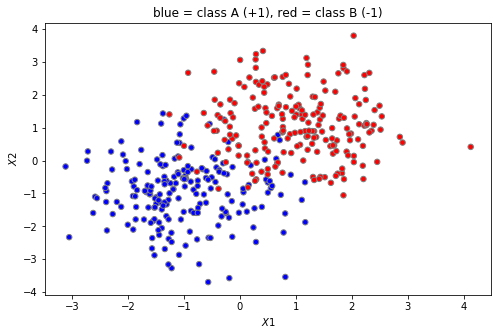

In [24]:
#plot the data points at first 
fig = plt.figure(figsize=(8, 5))
#fig = plt.figure()
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(X_n[:,0], X_n[:,1], edgecolors='gray', facecolors=['red' if y_i == -1 else 'blue' for y_i in y_n], s=30)
plt.ylabel('$X2$')
plt.xlabel('$X1$')
plt.title('blue = class A (+1), red = class B (-1)')
#plt.savefig('./ml_prog_assignment_1/prog1_results/2d_data.pdf')
plt.show()

# Plot Decision Boundary 
For tradeoff parameter C 

In [40]:
def plot_decision(X, w, b, S,C):
    support_vectors = X[S]
    margin = 1/np.linalg.norm(w)
    fig = plt.figure(figsize=(8, 5))
    #fig = plt.figure()
    gs = gridspec.GridSpec(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax.scatter(X[:,0], X[:,1], edgecolors='gray', facecolors=['red' if y_i == -1 else 'blue' for y_i in y], s=30)
    ax.scatter(support_vectors[:,0], support_vectors[:,1], c='black', s=30)

    y_eqn = w[0]*X[:,0] + w[1]*X[:,0] + b
    y_eqn1 = w[0]*X[:,0] + w[1]*X[:,0] + b + margin
    y_eqn2 = w[0]*X[:,0] + w[1]*X[:,0] + b - margin
    
    plt.plot(X[:,0] , y_eqn, 'g-')
    plt.plot(X[:,0] , y_eqn1, 'g--')
    plt.plot(X[:,0] , y_eqn2, 'g--')
    
    plt.axis('tight')
    plt.ylabel('$X2$')
    plt.xlabel('$X1$')
    plt.title('C = '+ str(C))
    #It is possible to save
    #plt.savefig('./ml_prog_assignment_1/prog1_results/svm_hyperplane_C_0.02.pdf')
    plt.show()

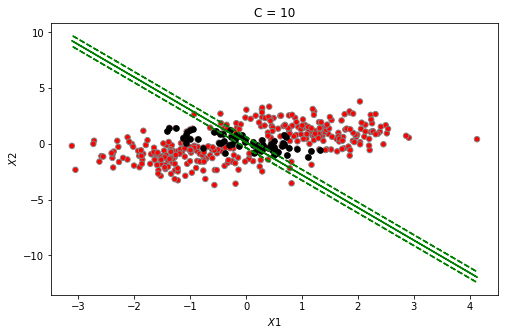

In [41]:
#plot decision when C =10 
C =10
w,b,S = svm_fit(X_n,y_n, linear_kernel, C)
plot_decision(X_n, w, b, S,C)

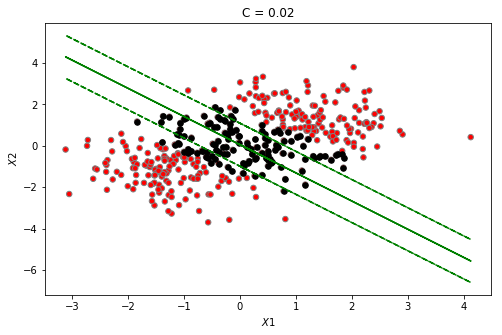

In [43]:
#plot decision when C =0.02
C =0.02
w,b,S = svm_fit(X_n,y_n, linear_kernel, C)
plot_decision(X_n, w, b, S,C)

# For MNIST
We will check similarly for MNIST digit dataset

In [ ]:
#Answer to Question 1 (C) - On MNIST

In [36]:
#Get the parameters at first by training on MNIST train samples
w,b,S = svm_fit(X,y, linear_kernel, 10) # C = 10
#w,b,S = fit(X,y, linear_kernel, 0.02) #C = 0.02

In [22]:
#Function for the predictions based on the parameters
def pred_test(X, w, b):
    dot_X_w_plus_b = np.dot(X, w) + b
    #print(dot_X_w_plus_b)
    #print(np.sign(dot_X_w_plus_b))
    return np.sign(dot_X_w_plus_b)

In [23]:
#Get the predictions on the test MNIST samples and get the generalization error
y_pred = pred_test(X_t, w, b)
num_of_correct = np.sum(y_pred == y_t)
gen_error = (len(y_t) - num_of_correct)/ len(y_t)
print('Total number of predictions correct: ', num_of_correct)
print('Total number of MNIST test smaples corresponding to 0 and 1 is: ', len(y_t))
print('So the generalization error on MNIST test smaples corresponding to 0 and 1 is: ',gen_error )

[-3.6305543  -2.61378413 -3.12822197 ...  2.77352011  2.44350167
  2.30510098]
[-1. -1. -1. ...  1.  1.  1.]
Total number of predictions correct:  2114
Total number of MNIST test smaples corresponding to 0 and 1 is:  2115
So the generalization error on MNIST test smaples corresponding to 0 and 1 is:  0.00047281323877068556
